In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

PATH = '/home/adriana/Projects/CNV/230404-fold80-investigation'

In [ ]:
run50HS = pd.read_csv(f'{PATH}/0050-hs-metrics.txt', sep='\t')
run42HS = pd.read_csv(f'{PATH}/0042-hs-metrics.txt', sep='\t')
run39HS = pd.read_csv(f'{PATH}/0039-hs-metrics.txt', sep='\t')
run50HS['Run'] = '0050'
run42HS['Run'] = '0042'
run39HS['Run'] = '0039'

run50FQ = pd.read_csv(f'{PATH}/0050-fastqc.txt', sep='\t')
run39FQ = pd.read_csv(f'{PATH}/0039-fastqc.txt', sep='\t')
run42FQ = pd.read_csv(f'{PATH}/0042-fastqc.txt', sep='\t')
run39FQ['Run'] = '0039'
run42FQ['Run'] = '0042'
run50FQ['Run'] = '0050'

In [ ]:
allrunsHS = pd.concat([run50HS, run42HS, run39HS])
plt.style.use('ggplot')

In [ ]:
sns.scatterplot(x='Sample', y='FOLD_80_BASE_PENALTY', hue='Run', data=allrunsHS)
plt.axhline(y=1.3,color='r',linestyle='--')
#plt.xticks(rotation=90)

In [ ]:
CNVsamples=allrunsHS.loc[allrunsHS['Sample'].str.startswith('C')]



In [ ]:
sns.scatterplot(x='Sample', y='FOLD_80_BASE_PENALTY', hue='Run', data=CNVsamples)
plt.axhline(y=1.3,color='r',linestyle='--')
plt.figszie=(500,100)
plt.xticks(rotation=90)

In [ ]:
CNVsamples.sort_values(by=['FOLD_80_BASE_PENALTY'],ascending=False)[['Sample'  ,'FOLD_80_BASE_PENALTY','Run']]

In [ ]:
import dxpy

In [ ]:
project_ids = []
projects=dxpy.bindings.search.find_projects(name="002_*A*_CEN",name_mode="glob",describe=True)
for project in projects:
    project_ids.append(project['describe']['id'])

In [ ]:
print(project_ids)

In [ ]:
example_id='project-GBkKPvQ4kYyF88304g4fzbYv'
example_id2='project-GPy5K684zvb1GXyBb1B2gxf6'
project_name=dxpy.api.project_describe(example_id)['name'][4:33]

hs_metrics = list(dxpy.bindings.search.find_data_objects(classname="file",describe=True, project=example_id2,name="multiqc_picard_HsMetrics.txt",name_mode="exact"))
live_files=[x for x in hs_metrics if x['describe']['archivalState'] == 'live']

if live_files:
    print(live_files)
else:
    print('No hs_metrics found')


In [ ]:

for project in project_ids:
    project_name=dxpy.api.project_describe(project)['name'][4:33]
    #print(project_name)
    hs_metrics = list(dxpy.bindings.search.find_data_objects(classname="file",describe=True, project=project,name="multiqc_picard_HsMetrics.txt",name_mode="exact"))
    live_files=[x for x in hs_metrics if x['describe']['archivalState'] == 'live']

    if live_files:
        dxpy.bindings.dxfile_functions.download_dxfile(live_files[0]['id'],filename=f'{project_name}-hs-metrics.txt',project=project)

In [4]:
import os
data=pd.DataFrame()
for filename in os.listdir(PATH):
    if filename.endswith("hs-metrics.txt"):
        run_name=filename[:-15]
        tmp_df=pd.read_csv(f'{PATH}/{filename}', sep='\t')
        tmp_df['Run']=run_name
        data = pd.concat([data,tmp_df])

<AxesSubplot:xlabel='FOLD_80_BASE_PENALTY', ylabel='Count'>

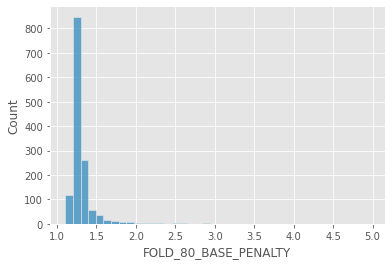

In [5]:
plt.style.use('ggplot')
sns.histplot(data=data.FOLD_80_BASE_PENALTY,bins=40)


<AxesSubplot:xlabel='FOLD_80_BASE_PENALTY', ylabel='Count'>

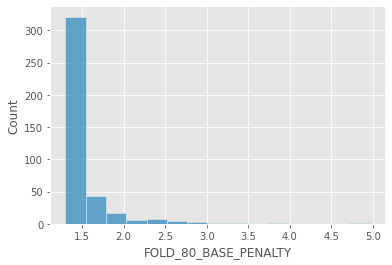

In [6]:
plt.style.use('ggplot')
above_cutoff=data.loc[data['FOLD_80_BASE_PENALTY']>1.3]
sns.histplot(data=above_cutoff.FOLD_80_BASE_PENALTY,bins=15)
#plt.ayhline(x=1.3,color='r',linestyle='--')

In [7]:
print(len(list(data.Run.unique())))
above_cutoff_high=data.loc[data['FOLD_80_BASE_PENALTY']>1.5]

print(len(list(above_cutoff_high.Run.unique())))
print(len(list(above_cutoff.Run.unique())))

29
23
29


<AxesSubplot:xlabel='FOLD_80_BASE_PENALTY', ylabel='Count'>

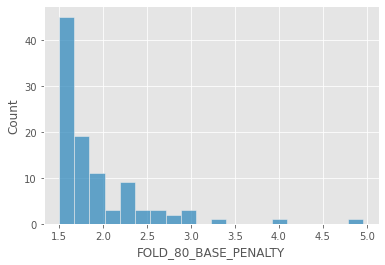

In [8]:
sns.histplot(data=above_cutoff_high.FOLD_80_BASE_PENALTY,bins=20)


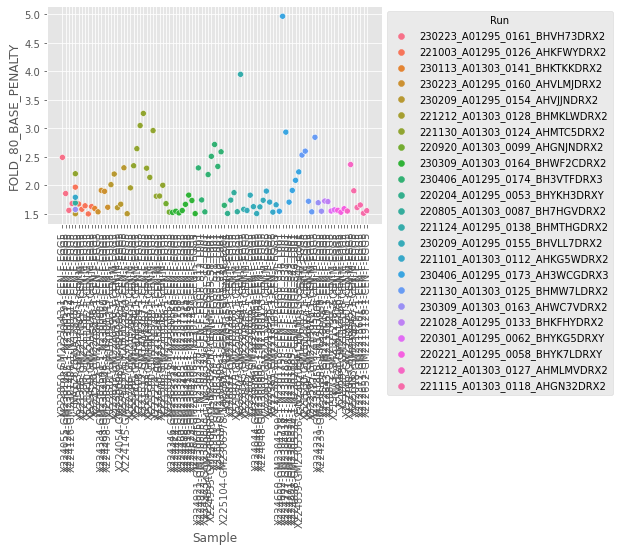

In [9]:
ax=sns.scatterplot(x='Sample', y='FOLD_80_BASE_PENALTY', hue='Run', data=above_cutoff_high)
sns.move_legend(ax, 'upper left',bbox_to_anchor=(1,1))
labels=plt.xticks(rotation=90)

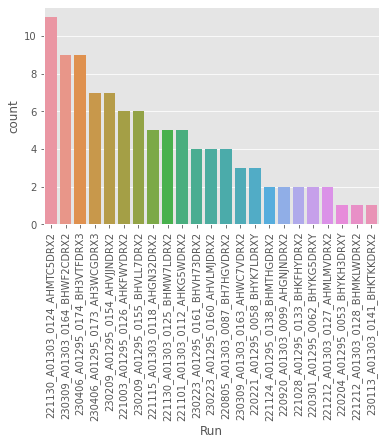

In [10]:
sns.countplot(x='Run', data=above_cutoff_high,order=above_cutoff_high['Run'].value_counts().index)
x=plt.xticks(rotation=90)

In [11]:
above_cutoff_high[above_cutoff_high.Sample.str.startswith('X224279')].FOLD_80_BASE_PENALTY


16    1.537622
Name: FOLD_80_BASE_PENALTY, dtype: float64

## Investigate in conjuction with gcnv.bed

Downloaded and unziped following file for run 124 file-GP6X5484GxyxP0JY5V9j2pY5


In [12]:
gcnv_124=pd.read_csv(f'{PATH}/002_221130_A01303_0124_AHMTC5DRX2_CEN_copy_ratios-chr20.gcnv.bed', sep='\t')
chr20_gcnv_mean = gcnv_124.mean().drop(['chr','start','end']).to_frame(name='CP-mean')
chr20_gcnv_mean

,CP-mean
X221539-GM1610658-1-CEN-M-EGG5,2.165077
X221543-GM1701755-1-CEN-F-EGG5,2.055141
X221505-GM1401654-1-CEN-M-EGG5,2.906112
X221491-GM1112489-1-CEN-F-EGG5,3.016221
X221512-GM1414267-1-CEN-F-EGG5,2.984016
X221508-GM1406304-1-CEN-F-EGG5,3.003935
X221577-GM1818200-1-CEN-F-EGG5,1.993701
X221533-GM1601267-1-CEN-F-EGG5,2.903912
X221590-GM1905799-1-CEN-F-EGG5,2.403166
X221595-GM1907328-1-CEN-F-EGG5,1.975914


In [17]:
subset124=data[data.Run=='221130_A01303_0124_AHMTC5DRX2'][['Sample','FOLD_80_BASE_PENALTY', 'HS_PENALTY_20X', 'HS_PENALTY_30X', 'HS_PENALTY_40X', 'HS_PENALTY_50X',
       'HS_PENALTY_100X']].sort_values(by=['FOLD_80_BASE_PENALTY'],ascending=False).set_index('Sample')

,FOLD_80_BASE_PENALTY,HS_PENALTY_20X,HS_PENALTY_30X,HS_PENALTY_40X,HS_PENALTY_50X,HS_PENALTY_100X
Sample,,,,,,
X221512-GM1414267-1-CEN-F-EGG5,3.261090,15.510974,15.733309,15.945977,16.189578,17.535187
X221508-GM1406304-1-CEN-F-EGG5,3.048774,15.643647,15.859470,16.062598,16.291117,17.479414
X221590-GM1905799-1-CEN-F-EGG5,2.960702,12.969212,13.075714,13.201580,13.323573,13.950965
X221505-GM1401654-1-CEN-M-EGG5,2.643749,11.886306,12.001847,12.094279,12.223685,12.852226
X221491-GM1112489-1-CEN-F-EGG5,2.344393,10.987352,11.075903,11.164453,11.253003,11.678045
X221533-GM1601267-1-CEN-F-EGG5,2.302142,11.211654,11.305637,11.399620,11.493604,12.044971
NA12878-NA12878-1-CEN-F-EGG5,2.204767,9.949629,10.012186,10.070275,10.126576,10.426850
X221539-GM1610658-1-CEN-M-EGG5,2.140503,10.221137,10.285979,10.355809,10.409678,10.756834
X222500-GM2215615-1-CEN-M-EGG5,2.003236,12.732394,12.874971,13.047566,13.187142,14.087633
